In this notebook, a section of a high-voltage cable is simulated (taken from the COMSOL project of EE4625 - High Voltage Cable Systems). The simulation is magnetostatics including a term for induced eddy currents. I hope that this will allow me to simulate the skin and proximity effect (the latter only for multiple cables!).

# Include Packages

In [1]:
using LinearAlgebra;
using Plots;

using gmsh;

using Gridap;
using GridapGmsh;

# Problem Definition
Section of cable.

Assumption: time-harmonic currents

## Geometry

In [2]:
ri = 19.1e-3;   # Cable inner radius
ro = 37.5e-3;   # Cable outer radius

lc1 = 2e-3;      # Mesh density at outside of cable
lc2 = 0.1e-3;   # Mesh density at the conductor edge

## Materials & Sources

In [3]:
I = 1000;            # Current in the cable [A]

mu0 = 4*pi*1e-7;     # Permeability of vacuum
omega = 2*pi*50;     # Frequency of the time-harmonic current

sigma_cond = 3.69e7;   # Conductivity of aluminium

# Define Geometry in gmsh

In [139]:
gmsh.finalize()
gmsh.initialize()

gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("cable_skin")

# Points
gmsh.model.geo.addPoint(0, 0, 0, lc1, 1);
gmsh.model.geo.addPoint(ri, 0, 0, lc2, 2);
gmsh.model.geo.addPoint(ro, 0, 0, lc1, 3);
gmsh.model.geo.addPoint(0, ri, 0, lc2, 4);
gmsh.model.geo.addPoint(0, ro, 0, lc1, 5);

# Lines
gmsh.model.geo.addLine(1, 2, 1);
gmsh.model.geo.addLine(2, 3, 2);
gmsh.model.geo.addLine(1, 4, 3);
gmsh.model.geo.addLine(4, 5, 4);
gmsh.model.geo.addCircleArc(2, 1, 4, 5);
gmsh.model.geo.addCircleArc(3, 1, 5, 6);

# Surfaces
gmsh.model.geo.addCurveLoop([1, 5, -3], 1)
gmsh.model.geo.addCurveLoop([2, 6, -4, -5], 2)

gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)

# Physics
#  Dirichlet boundary on outside of cable
gmsh.model.addPhysicalGroup(0, [3, 5], 1)
gmsh.model.setPhysicalName(0, 1, "D1p")
gmsh.model.addPhysicalGroup(1, [6], 1)
gmsh.model.setPhysicalName(1, 1, "D1")

#  Neumann boundary on two insides
gmsh.model.addPhysicalGroup(0, [1, 2, 4], 2)
gmsh.model.setPhysicalName(0, 2, "N1p")
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4], 2)
gmsh.model.setPhysicalName(1, 2, "N1")

#  Material groups
gmsh.model.addPhysicalGroup(2, [1], 1)
gmsh.model.setPhysicalName(2, 1, "conductor")
gmsh.model.addPhysicalGroup(2, [2], 2)
gmsh.model.setPhysicalName(2, 2, "insulator")

# Generate mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("cable_skin.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Circle)
Info    : Done meshing 1D (Wall 0.0721171s, CPU 0.015625s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.57751s, CPU 0.453125s)
Info    : 7673 nodes 15650 elements
Info    : Writing 'cable_skin.msh'...
Info    : Done writing 'cable_skin.msh'


In [140]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


# Gridap

In [141]:
# Load geometry from gmsh
model = GmshDiscreteModel("cable_skin.msh")

# Create a reference Lagrangian finite element space to use for the construction of test space V0
order = 3
reffe = ReferenceFE(lagrangian, Float64, order);
# The test space is created from the reference FE with
#  conformity = H1: shape functions are continuous
#  D1 and D2 being the boundary points with Dirichlet condition applied
#  vector_type = ComplexF64 to allow for a complex input & output
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = ["D1", "D1p"], vector_type=Vector{ComplexF64});

# Trial space is constructed from the test space, giving the proper values for the Dirichlet boundary
Ug = TrialFESpace(V0, [0, 0]);

# Triangulation of the domain
#  degree must be at least 2 times the order of the reference space
degree = 2 * order;
Ω = Triangulation(model);
dΩ = Measure(Ω, degree);

Ω_c = Triangulation(model, tags = "conductor")
dΩ_c = Measure(Ω_c, degree)

Jsource = I / (pi * ri*ri);

uh = 0;

M = 2;
for i = 1:M
    # Define source functions
    #  How to use Gridap to assign these to elements instead of positions?
    fsource(x) = Jsource * (sqrt(x[1]*x[1] + x[2]*x[2]) < ri);
    cfun(x) = 1 / mu0;
    sigmafun(x) = 1im * omega * sigma_cond * (sqrt(x[1]*x[1] + x[2]*x[2]) < ri);

    # Construct weak form
    lhs(u,v) = ∫( cfun * ∇(v) ⋅ ∇(u) + sigmafun * u ⋅ v )dΩ;
    rhs(v)   = ∫( v * fsource  )dΩ;

    # Construct FE operator with LHS, RHS, and test and trial spaces
    op = AffineFEOperator(lhs, rhs, Ug, V0);

    # Solve the linear FE system with LU solver
    ls = LUSolver()
    solver = LinearFESolver(ls)

    uh = solve(solver, op);
    
    ## Correct the coil current to ensure Icoil = I
    J = laplacian(uh) / mu0;
    Icoil = norm(sum(∫(J)dΩ_c)) * 4;
    Jsource = Jsource * I / Icoil;
    print("Icoil: ", Icoil, "\n")
end

Info    : Reading 'cable_skin.msh'...
Info    : 13 entities
Info    : 7673 nodes
Info    : 15349 elements
Info    : Done reading 'cable_skin.msh'
Icoil: 375.1889726942711
Icoil: 999.9999999997781


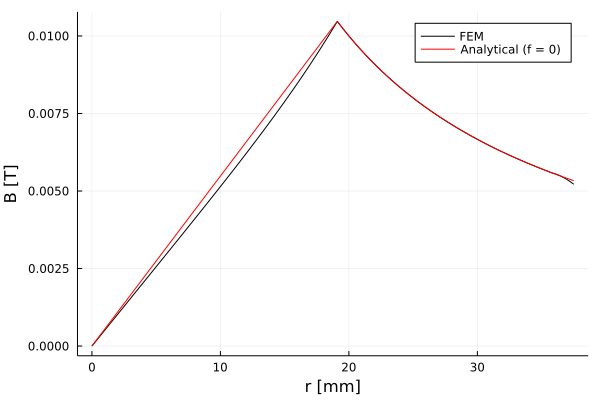

In [142]:
B = ∇(uh);
J = laplacian(uh) / mu0;

x = Vector(0:ro/1000:ro)
coord = [Point(x[i], 0) for i in 1:length(x)];
u_line = uh(coord);
B_line = B(coord);
J_line = J(coord);

B_line = [(sqrt(norm(B[1])^2 + norm(B[2])^2))  for B in B_line];

p1 = Plots.plot(x * 1e3, B_line, color = :black, xlabel = "r [mm]", ylabel = "B [T]", label = "FEM")
p1 = Plots.plot!(x * 1e3, mu0 * I ./ (2*pi*ri^2) .* x .* (x .< ri) + mu0 * I ./ (2 * pi * x) .* (x .>= ri), color = :red, label = "Analytical (f = 0)")

Because the total current flowing through the cable must stay $I$, the magnetic field at the edge of the conductor must always have the same value, no matter the frequency.
$$ B(r_i) = \frac{\mu_0 I}{2\pi r_i} $$
The same goes for the magnetic field outside the conductor. Because of the eddy currents, the distribution inside the conductor may change with frequency.

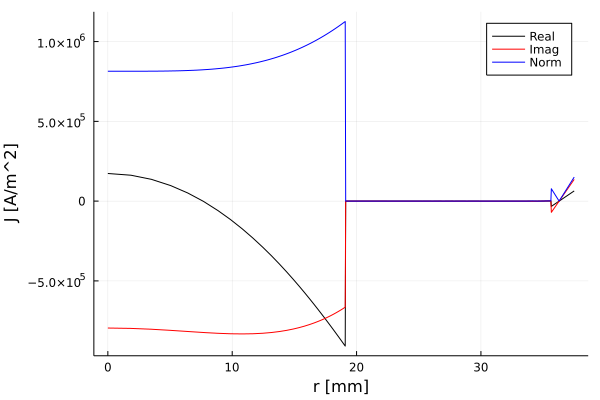

In [143]:
p2 = Plots.plot(x * 1e3, real(J_line), color = :black, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Real")
p2 = Plots.plot!(x * 1e3, imag(J_line), color = :red, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Imag")
p2 = Plots.plot!(x * 1e3, norm.(J_line), color = :blue, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Norm")

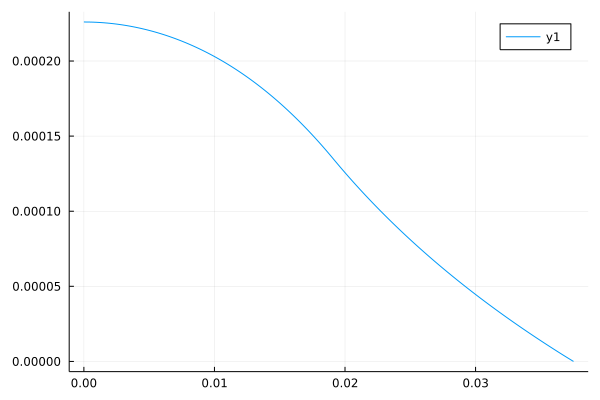

In [144]:
Plots.plot(x, norm.(u_line))

In [145]:
maximum(norm.(u_line))

0.00022597208246448743

# Write to VTK

In [211]:
writevtk(Ω,"cable_skin",cellfields=["A"=>abs(uh), "J"=>abs(J)])

(["cable_skin.vtu"],)

# 2D FEM Implementation

In [4]:
using GR

In [5]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)

In [6]:
struct mesh_data
    nnodes
    xnode
    ynode
    
    nelements
    element_connectivity
    e_group
end

function get_mesh_data()
    #..2/11 Get and sort the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]
    
    #..4/12 Get the mesh elements
    #..observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelements = length(element_ids[1])

    #..5/12 Create groups of elements for the subdomains
    #..for loop that creates a vector describing which physical group an element belongs to
    ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
    ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 2)
    e_group = zeros(1,nelements)
    for element_id in 1:nelements
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]
        G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Conductor
        G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) # Insulator
        if G1 == 3
            e_group[element_id] = 1;
        elseif G2 == 3
            e_group[element_id] = 2;
        end
    end
    
    return mesh_data(nnodes, xnode, ynode, nelements, element_connectivity, e_group)
end

get_mesh_data (generic function with 1 method)

In [7]:
gmsh.open("cable_skin.msh")
mshdata = get_mesh_data();

Info    : Reading 'cable_skin.msh'...
Info    : 13 entities
Info    : 7673 nodes
Info    : 15349 elements
Info    : Done reading 'cable_skin.msh'


In [42]:
Ic = 1000;            # Current in the cable [A]

mu0 = 4*pi*1e-7;     # Permeability of vacuum
omega = 2*pi*1000;     # Frequency of the time-harmonic current

#..6/12 Define the source function and the reluctivity function
Jsource = Ic / (pi * ri*ri);
sourcefunction(group_id) = Jsource * (group_id == 1)
sourceperelement = map(sourcefunction, mshdata.e_group);

reluctivityfunction(group_id) = 1/ mu0;
reluctivityperelement = map(reluctivityfunction, mshdata.e_group);

sigma_cond = 3.69e7;   # Conductivity of aluminium
conductivityfunction(group_id) = sigma_cond * (group_id == 1)
conductivityperelement = map(conductivityfunction, mshdata.e_group);

In [49]:
#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
N = mshdata.nnodes + 1;
A = zeros(Complex{Float64}, N, N)
f = zeros(Complex{Float64}, N, 1)

element_connectivity = mshdata.element_connectivity;
xnode = mshdata.xnode;
ynode = mshdata.ynode;

#..8/12 Perform a loop over the elements
for element_id in 1:mshdata.nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

    #....compute surface area of the current element
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

    #....compute local vector contribution floc of the current element
    #floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]

    #....compute local matrix contribution Aloc of the current element
    Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]] \ UniformScaling(1.);
    Emat[3,:] .= 0;
    Bloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);
    Cloc = 1im * area_id / 3 * conductivityperelement[element_id] * omega * Diagonal(ones(3));

    #....add local contribution to f and A
    I      = element_connectivity[1][3 * (element_id - 1) .+ (1:3)];
    #f[I]   += floc;
    A[I,I] += (Bloc + Cloc);
    
    # Modify A and f with circuit equation
    f[N] = Ic / 4;
    if(mshdata.e_group[element_id] == 1)
        A[I,end] += -4/(pi*ri*ri) * area_id/3 * [1;1;1];
        A[end, I] += -1im * omega * conductivityperelement[element_id] * area_id/3 * [1;1;1];
    end
end
A[end,end] = 1;

#..9/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,5)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(1,6)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..10/12 Compute the numerical solution
u = A \ f;

In [50]:
maximum(norm.(u[1:end-1]))

0.00015243044148161527

In [51]:
norm.(u[end])*4

39652.732433295

In [46]:
xel = zeros(mshdata.nelements);
yel = zeros(mshdata.nelements);
Jel = zeros(Complex{Float64}, mshdata.nelements);

Ic = 0;
for element_id in 1:mshdata.nelements
    #....retrieve global numbering of the local nodes of the current element
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]

    #....retrieve the x and y coordinates of the local nodes of the current element
    xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
    ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];
    
    #....compute surface area of the current element
    x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
    y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
    area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2
    
    xel[element_id] = (xnode1 + xnode2 + xnode3) / 3;
    yel[element_id] = (ynode1 + ynode2 + ynode3) / 3;
    if(mshdata.e_group[element_id] == 1)
        Jel[element_id] = 4*u[end] / (pi * ri*ri) - 1im * omega * conductivityperelement[element_id] * 1/3 * sum(u[[node1_id, node2_id, node3_id]]);
        Ic = Ic + Jel[element_id] * area_id * 4;
    end
end

In [47]:
norm.(Ic)

999.9822469160135

# Write to VTK

In [35]:
using WriteVTK

In [48]:
# Define nodes (points) and elements (cells)
points = [mshdata.xnode mshdata.ynode]';
cells = [MeshCell(VTKCellTypes.VTK_TRIANGLE, mshdata.element_connectivity[1][3*(i-1).+(1:3)]) for i = 1:mshdata.nelements];

# Create VTK file structure using nodes and elements
vtkfile = vtk_grid("cable_skin2.vtu", points, cells);

# Store data in the VTK file
vtkfile["A", VTKPointData()] = norm.(u[1:end-1]);
vtkfile["J", VTKCellData()]  = norm.(Jel);

# Save the file
outfiles = vtk_save(vtkfile);